In [1]:
from collections import Counter
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

# Data loading and formatting

In [2]:
wdir = os.path.abspath('../../Desktop/eLearn/COVIDx/COVID-Net/')

In [3]:
train = pd.read_csv(wdir + '/train_split_v3.txt', sep=' ', skiprows=75, header=None)
train.columns = ['Id', 'image', 'label', 'meta_1', 'meta_2']
train = train.loc[:,['Id', 'image', 'label']]
train.head()

,Id,image,label
0,53,446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg,COVID-19
1,54,80446565-E090-4187-A031-9D3CEAA586C8.jpeg,COVID-19
2,55,7E335538-2F86-424E-A0AB-6397783A38D0.jpeg,COVID-19
3,56,D7AF463C-2369-492D-908D-BE1911CCD74C.jpeg,COVID-19
4,57,all14238-fig-0001-m-b.jpg,COVID-19


In [4]:
test  = pd.read_csv(wdir + '/test_split_v3.txt', sep=' ', header=None)
test.columns = ['Id', 'image', 'label']
test.head()

,Id,image,label
0,8,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia
1,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
2,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
3,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
4,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia


# Check for data leakage between train and test

In [5]:
#Check for potential data leakage
print('Found {} data leakage cases between train and test'.format(len(set(train.Id).intersection(set(test.Id)))))

Found 0 data leakage cases between train and test


# Label distributions

In [6]:
def df_from_counter(train, test):
    t1 = Counter(train)
    t2 = Counter(test)
    t1 = pd.DataFrame({'labels':list(t1.keys()),
                       'count':list(t1.values()),
                       'data':'train'})
    t2 = pd.DataFrame({'labels':list(t2.keys()),
                       'count':list(t2.values()),
                       'data':'test'})
    return pd.concat([t1, t2])

In [7]:
#Plot class distribution
datadf = df_from_counter(train.loc[train.label != 'xx',:].label, test.label)
fig = px.bar(datadf, x='labels', y='count', color='data', barmode='group', 
             title='Label distribution in COVIDx V3 dataset', )
fig.show()

# Raw image inspection

Display Random normal Images


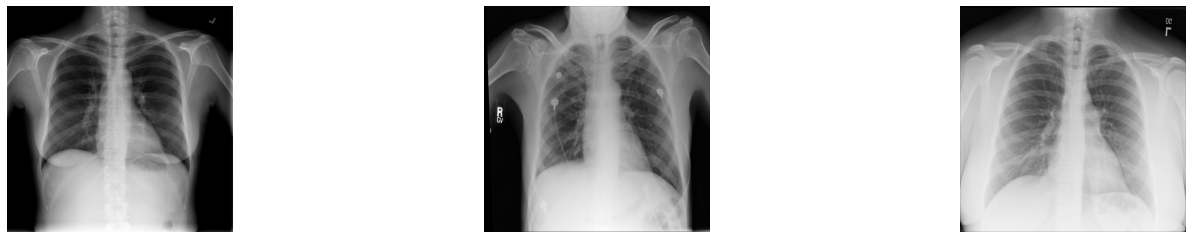

Display Random pneumonia Images


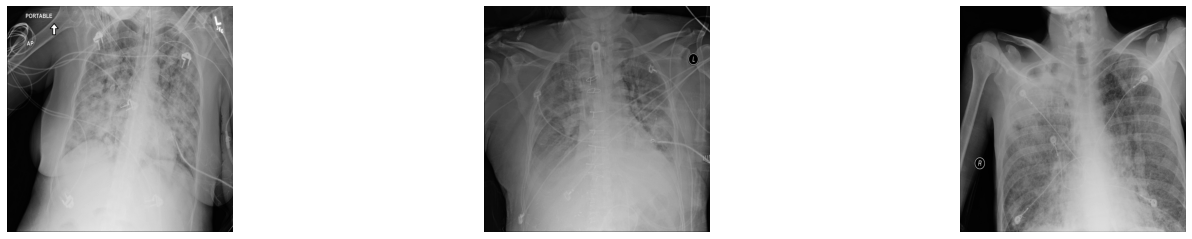

Display Random COVID-19 Images


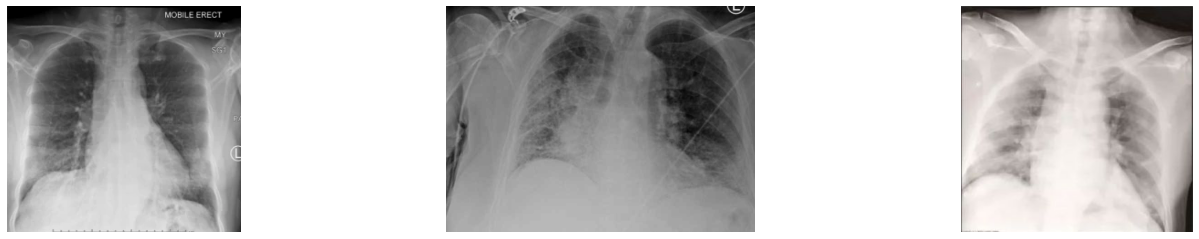

In [8]:
def plot_row(label):

    # Extract numpy values from Image column in data frame
    images = train.loc[train.label == label]['image'].values

    # Extract 9 random images from it
    random_images = [np.random.choice(images) for i in range(3)]

    # Location of the image dir
    img_dir = '/Users/lucas_miranda/Desktop/eLearn/COVIDx/data/train/{}'.format(label)

    print('Display Random {} Images'.format(label))

    # Adjust the size of your images
    plt.figure(figsize=(20,10))

    # Iterate and plot random images
    for i in range(3):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(os.path.join(img_dir, random_images[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()
    plt.show()
    
plot_row('normal')
plot_row('pneumonia')
plot_row('COVID-19')

The dimensions of the image are 2048 pixels width and 2500 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 153.2274 and the standard deviation is 63.9146


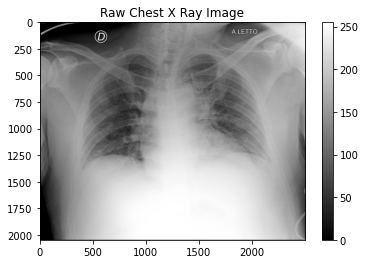

In [9]:
# Get the first image that was listed in the train_df dataframe
sample_img = train.image[0]
img_dir = '/Users/lucas_miranda/Desktop/eLearn/COVIDx/data/train/{}'.format('COVID-19')
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

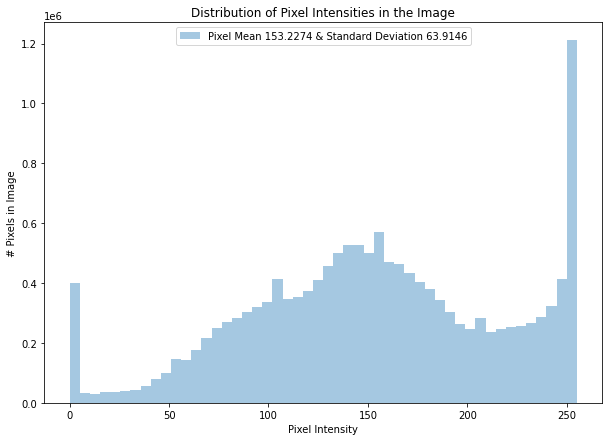

In [10]:
# Plot a histogram of the distribution of the pixels
plt.figure(figsize=(10, 7))

sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

# Data generators

In [11]:
train_datagen = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization= True,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False,
)

In [12]:
# Flow from directory with specified batch size and target image size
generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory=img_dir,
        x_col="image", # features
        y_col= "label", # labels
        class_mode="raw", # 'Mass' column should be in train_df
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        target_size=(331,331) # width and height of output image
)

Found 176 validated image filenames.


/Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning:

Found 13389 invalid image filename(s) in x_col="image". These filename(s) will be ignored.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 331 pixels width and 331 pixels height
The maximum pixel value is 1.7993 and the minimum is -2.5072
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


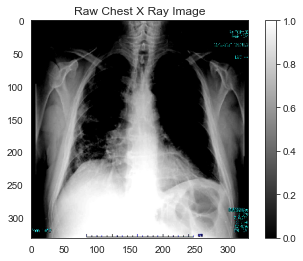

In [13]:
# Plot a processed image
sns.set_style("white")
generated_image, label = generator.__getitem__(1)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

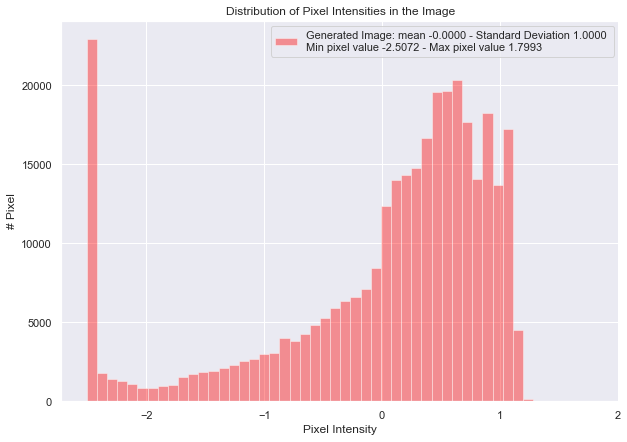

In [14]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4f} - Max pixel value {np.max(generated_image[0]):.4f}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()